In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.emulator as em
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors as pr
import matplotlib.pyplot as plt
import scipy as sc

In [3]:
# initalise fsps emulator
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [4]:
# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0

bins = np.arange(minz, maxz, dz)

In [5]:
bounds = hyp.hyperparameter_tighter()
nhypersamples = 5
hyperparameter_samples = np.vsplit(hyp.sample_prior_parameters(nhypersamples, bounds[0], bounds[1]), nhypersamples)

In [6]:
prior_data = pr.preload_prior_data(zmax=7.0)

In [7]:
nsamples = 100000
nzs = []
spsp = []
for row in hyperparameter_samples:
    sps_params = pop.generate_sps_parameters(nsamples, row[0], prior_data, uniform_redshift_mass=False, uniform_logf=False)
    lbg_nzs = nz.simulate_nzs(sps_params, model, 1000)
    nzs.append(lbg_nzs)
    spsp.append(sps_params)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/photerr/model.py:201: RuntimeWarning: overflow encountered in power
  x = 10 ** (0.4 * (mags - m5))
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/photerr/model.py:205: RuntimeWarning: overflow encountered in square
  nsrRandSingleExp = np.sqrt((0.04 - gamma) * x + gamma * x**2)
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/photerr/model.py:362: RuntimeWarning: overflow encountered in power
  fluxes = 10 ** (mags / -2.5)
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/photerr/model.py:363: RuntimeWarning: invalid value encountered in multiply
  obsFluxes = fluxes * (1 + rng.normal(scale=nsr))
/Users/fpetri/anaconda3/envs/tf_env/l

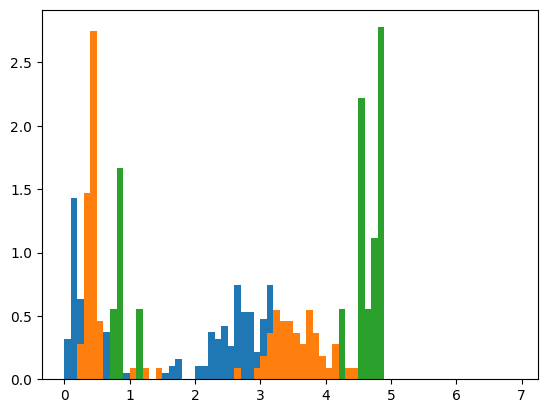

In [20]:
indx = 0
hist = plt.hist(nzs[indx][0], density=True, bins=bins)
hist = plt.hist(nzs[indx][1], density=True, bins=bins)
hist = plt.hist(nzs[indx][2], density=True, bins=bins)

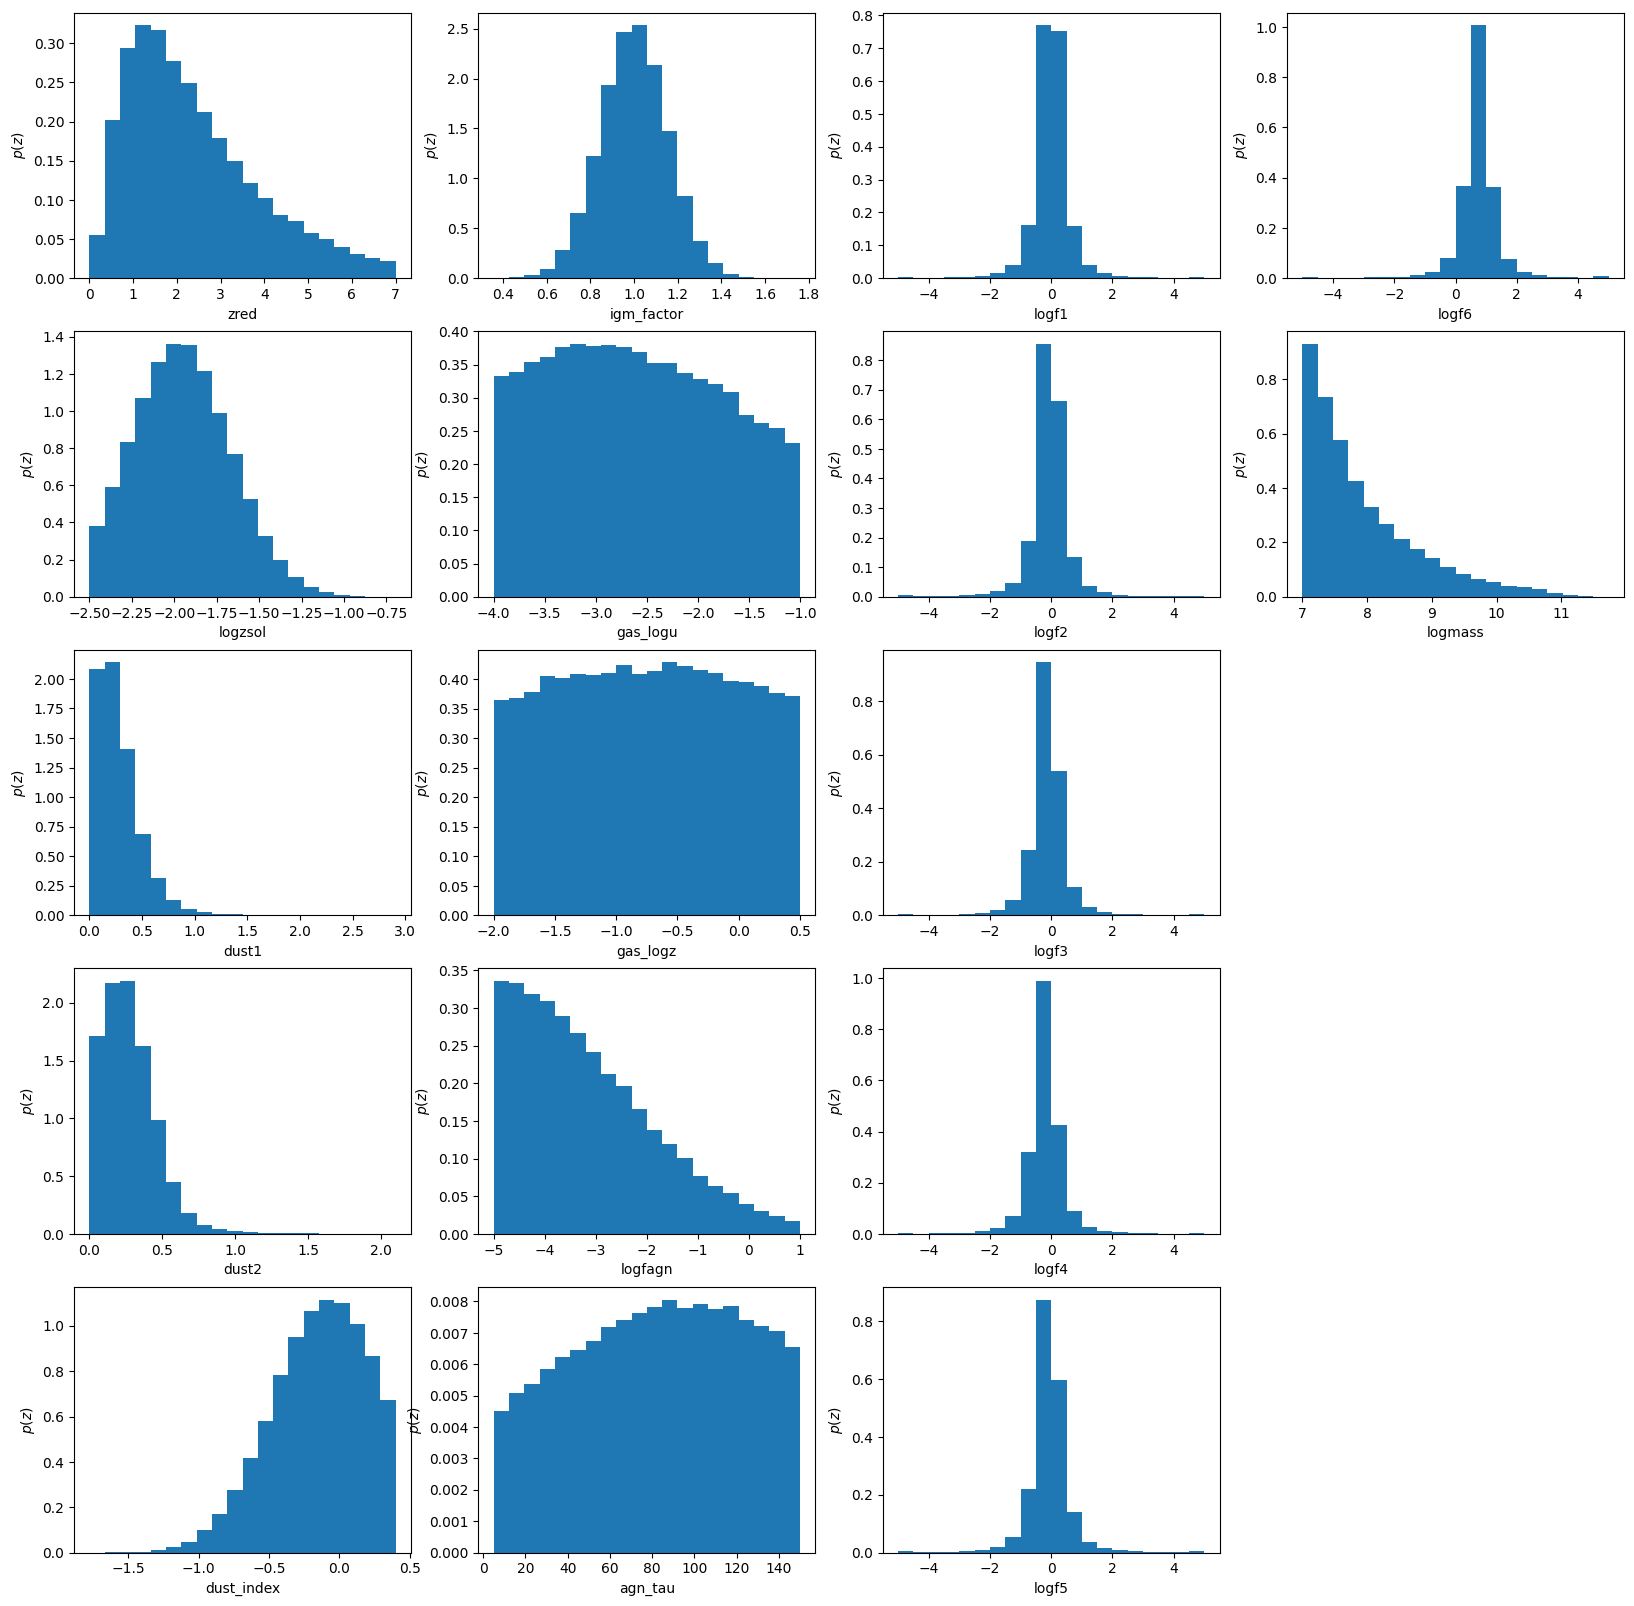

In [ ]:
pop.plot_galaxy_population(spsp[indx])

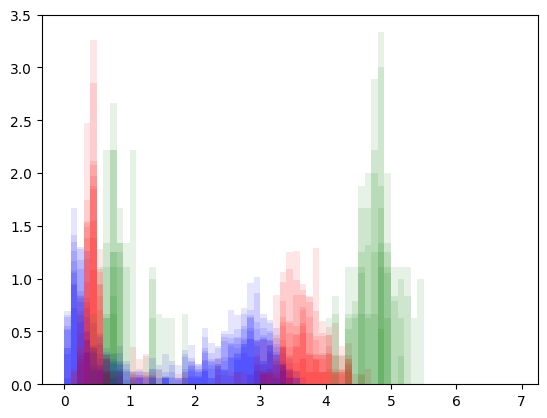

In [ ]:
for ind in range(nhypersamples):
    hist = plt.hist(nzs[ind][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[ind][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[ind][2], density=True, bins=bins, alpha = 0.1, color='green')

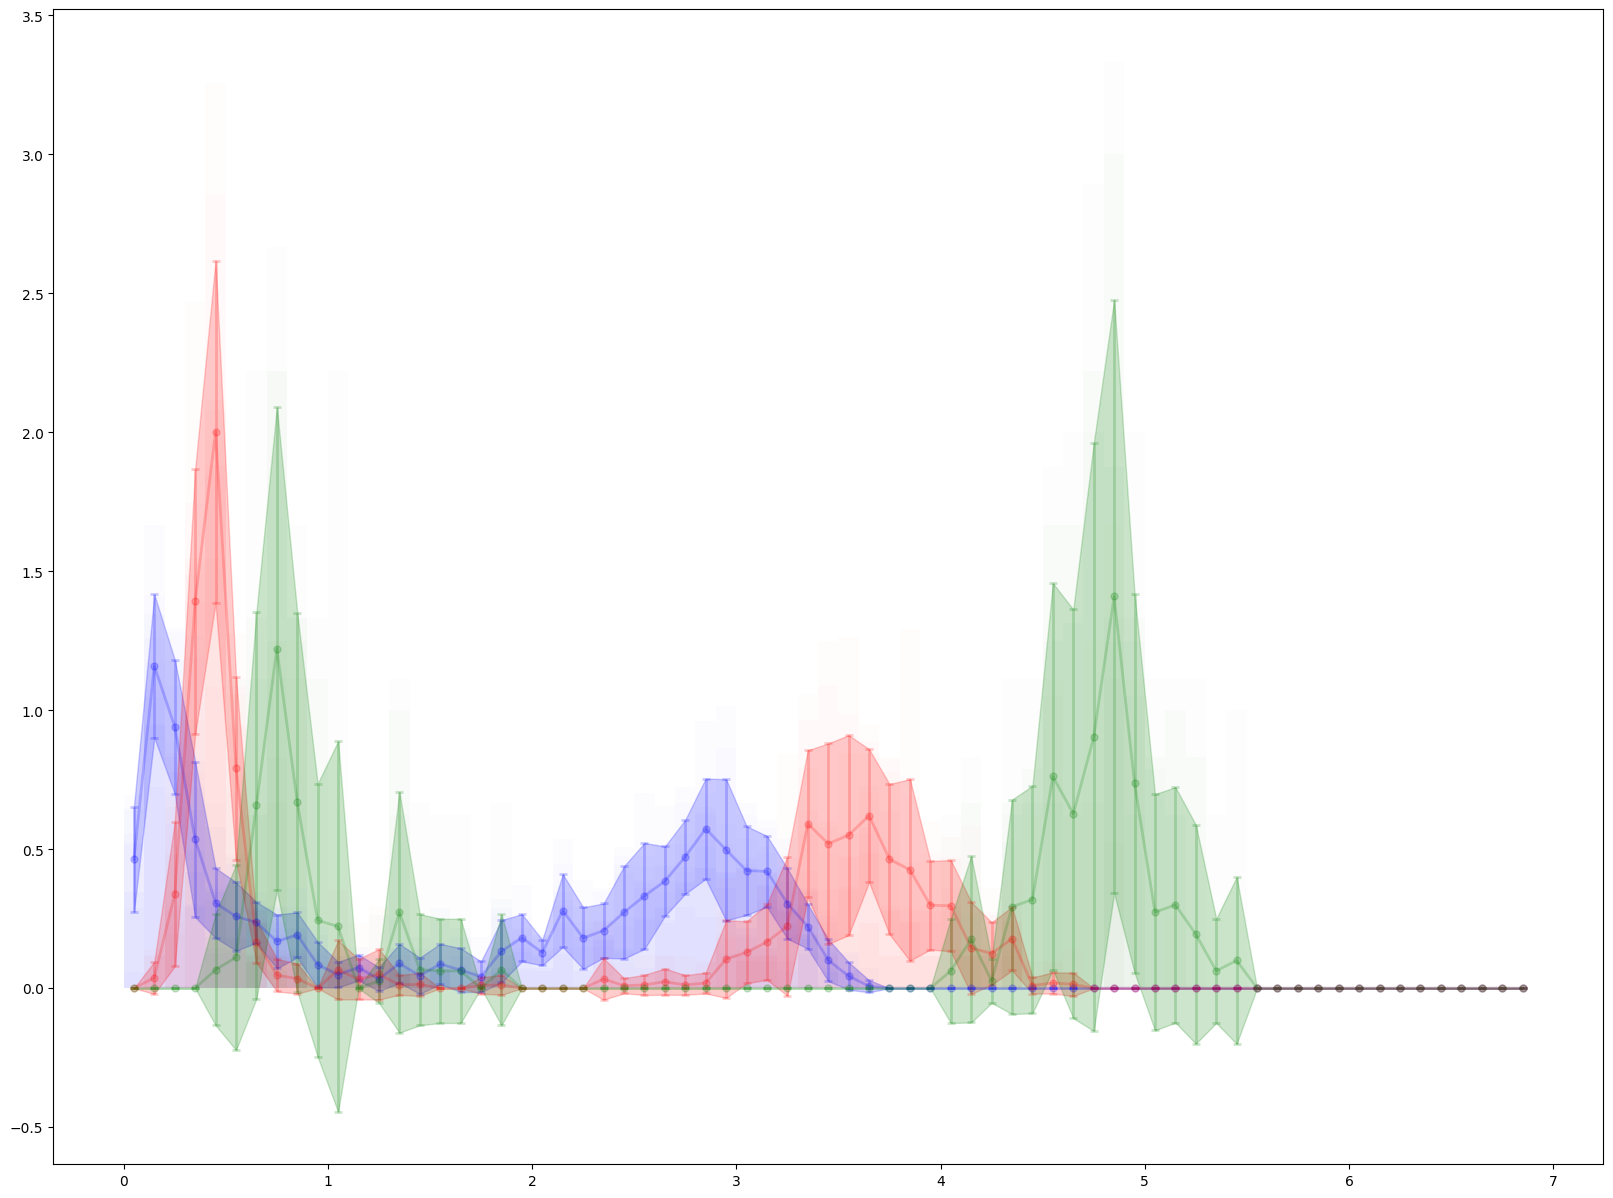

In [ ]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for ind in range(nhypersamples):
        hist = axes.hist(nzs[ind][drop], density=True, bins=bins, alpha = 0.01, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

[0.5069444444444444, 0.463768115942029, 0.39826839826839827, 0.45185185185185184, 0.427536231884058, 0.5128205128205128, 0.4444444444444444, 0.5, 0.38095238095238093, 0.5506329113924051]
[0.3786407766990291, 0.504950495049505, 0.3, 0.4583333333333333, 0.3132530120481928, 0.5176470588235295, 0.7209302325581395, 0.5492957746478874, 0.5476190476190477, 0.6941176470588235]
[0.25, 0.375, 0.02631578947368421, 0.1875, 0.1, 0.3333333333333333, 0.7777777777777778, 0.4444444444444444, 0.4, 0.6666666666666666]


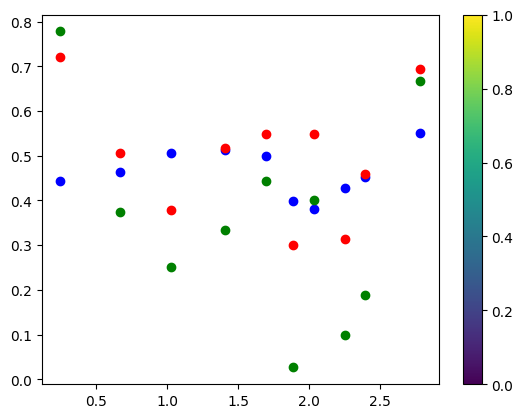

In [ ]:
def calculate_interloper_fraction(nz_redshift_samples):

    nint = len(np.where(nz_redshift_samples < 1.5)[0])
    tot = nz_redshift_samples.shape[0]
    return nint/tot

def calculate_highz_fraction(sps_parameter_samples):

    n_high_z = (np.where(sps_parameter_samples[:, 0] > 2.5)[0]).shape[0]
    n_tot = sps_parameter_samples[:, 0].shape[0]

    return n_high_z/n_tot

def calculate_highm_fraction(sps_parameter_samples):
    
    n_high_m = (np.where(sps_parameter_samples[:, -1] > 10**9)[0]).shape[0]
    n_tot = sps_parameter_samples[:, -1].shape[0]

    return n_high_m/n_tot

interloper_fractions = []
hyperparameters = []
highz_fracs = []
highm_fracs = []

ndropouts = 3
colours = ['blue', 'red', 'green']
for dropout in range(ndropouts):
    hyperparameters = []
    interloper_fractions = []
    highz_fracs = []
    highm_fracs = []
    for index in range(nhypersamples):
        interloper_fractions.append(calculate_interloper_fraction(nzs[index][dropout]))
        hyperparameters.append(hyperparameter_samples[index][0][11])# 6, 7, 10, 19  sus?
        highz_fracs.append(calculate_highz_fraction(spsp[index]))
        highm_fracs.append(calculate_highm_fraction(spsp[index]))
    plt.scatter(hyperparameters, interloper_fractions, color=colours[dropout])
    #plt.scatter(highm_fracs, highz_fracs, c=interloper_fractions, cmap='Reds')
    print(interloper_fractions)
plt.colorbar()


In [ ]:
#np.save("nzs_test.npy", nzs)
#np.save("spsp_test.npy", spsp)